<a href="https://colab.research.google.com/github/DeanIA/dl4m_final/blob/main/mapbox_rgb_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up
Import Libraries

In [1]:
# import libraries
import os
import math
import requests
import shutil
from google.colab import drive
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import preprocess_input
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers, models, applications, backend
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix


Mount and set working directory. Change the values below if your Drive is set up differently.

In [2]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/dl4m_final_project/

Mounted at /content/drive
/content/drive/MyDrive/dl4m_final_project


# Import Data

## Import census data

In [3]:
c = pd.read_csv('data/parsed/tract_data.csv')

print(c.head())

   Unnamed: 0                geo_id    NAME        lon        lat  \
0           1  1400000US36093033102  331.02 -74.180507  42.779891   
1           2  1400000US36093020102  201.02 -73.916141  42.829537   
2           3  1400000US36093032504  325.04 -74.031123  42.910368   
3           4  1400000US36081003400   34.00 -73.858187  40.684773   
4           5  1400000US36081003900   39.00 -73.940932  40.762799   

    pop_density  pop_dens_log  density_label  
0     82.879449      4.429381            1.0  
1   6961.953574      8.848359            2.0  
2     87.483183      4.482813            1.0  
3  31469.229320     10.356797            3.0  
4  25975.551364     10.164950            3.0  


## Import images

This is a helper function to load in the images from a specified directory. This takes in the folder name, ideal size (for VGG-16 this is 224, 224), and a limit if you only want to import some of the images.

In [4]:
def load_rgb_images(directory_path, target_size=None, limit=None):
    """
    Loads RGB images from `directory_path` into a NumPy array.

    Args:
      directory_path (str): path to folder containing .png/.jpg images
      target_size (tuple or None): (width, height) to resize each image;
                                   if None, leaves original size
      limit (int or None): if set, only load this many images (first n)

    Returns:
      images (np.ndarray): shape (n_images, height, width, 3), dtype float32
      paths (List[str]): the file paths in the same order
    """
    # list all image files
    files = sorted([
        f for f in os.listdir(directory_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    if limit is not None:
        files = files[:limit]

    images = []
    paths = []
    for fname in files:
        path = os.path.join(directory_path, fname)
        img = Image.open(path).convert('RGB')
        if target_size is not None:
            img = img.resize(target_size)
        arr = np.array(img, dtype=np.float32) / 255.0
        images.append(arr)
        paths.append(path)

    images = np.stack(images, axis=0)
    return images, paths


Import images using the helper function from above. Specificy the directory by changing the name of the folder that contains all of the images. This function will then upload all images in the specified size.

Directories of interest:


*   NY census tract centroids, zoom level 17: **images_20250422_031103**
*   NY census tract centroids: zoom level 16: **images_20250423_194433**



In [5]:
# set file name that you want to load
image_dir = 'images_20250422_031103'

image_dir_path = 'data/raw/mapbox/' + image_dir

# load images, set at target size of (224, 224)
imgs, img_paths = load_rgb_images(
    directory_path = image_dir_path,
    target_size    = (224, 224)
    )

print('loaded', imgs.shape, 'from', len(img_paths), 'files')
# e.g. loaded (150, 224, 224, 3) from 150 files


loaded (5411, 224, 224, 3) from 5411 files


In [6]:
img_paths[0:5]

['data/raw/mapbox/images_20250422_031103/1400000US36001000100.png',
 'data/raw/mapbox/images_20250422_031103/1400000US36001000201.png',
 'data/raw/mapbox/images_20250422_031103/1400000US36001000202.png',
 'data/raw/mapbox/images_20250422_031103/1400000US36001000301.png',
 'data/raw/mapbox/images_20250422_031103/1400000US36001000302.png']

Clean-up the files to make sure the labels are aligned.

In [7]:
# pull out only the geo_id
img_geo_ids = [
    os.path.splitext(os.path.basename(p))[0]
    for p in img_paths
]

img_geo_ids[0:5]

['1400000US36001000100',
 '1400000US36001000201',
 '1400000US36001000202',
 '1400000US36001000301',
 '1400000US36001000302']

Validate that the images are being indexed correctly.

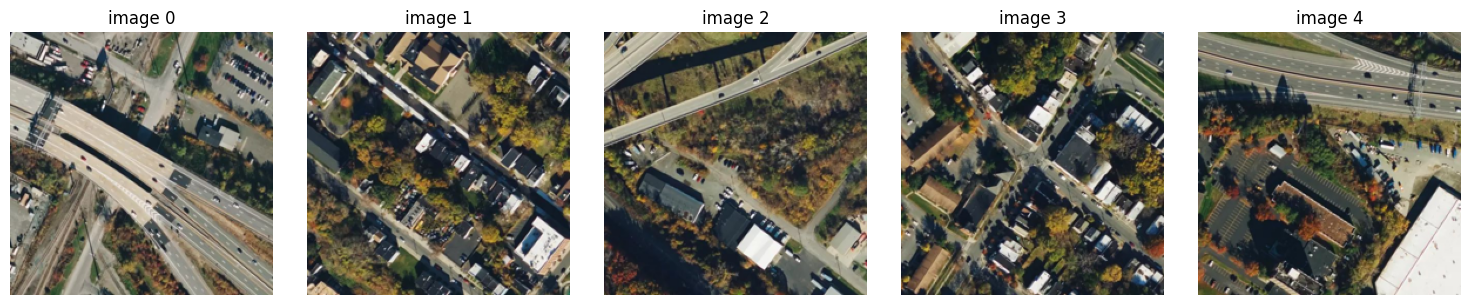

In [8]:
import matplotlib.pyplot as plt

n = 5
fig, axes = plt.subplots(1, n, figsize=(n*3, 3))

for i, ax in enumerate(axes):
    img = imgs[i]
    if img.dtype != 'uint8':
        img = (img * 255).astype('uint8')
    ax.imshow(img)
    ax.set_title(f'image {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [9]:
c.head()

,Unnamed: 0,geo_id,NAME,lon,lat,pop_density,pop_dens_log,density_label
0,1,1400000US36093033102,331.02,-74.180507,42.779891,82.879449,4.429381,1.0
1,2,1400000US36093020102,201.02,-73.916141,42.829537,6961.953574,8.848359,2.0
2,3,1400000US36093032504,325.04,-74.031123,42.910368,87.483183,4.482813,1.0
3,4,1400000US36081003400,34.00,-73.858187,40.684773,31469.229320,10.356797,3.0
4,5,1400000US36081003900,39.00,-73.940932,40.762799,25975.551364,10.164950,3.0


## Get data set-up for modeling

In [10]:
# generate df of geo_id's
img_df = pd.DataFrame({'geo_id': img_geo_ids})

# left join to pull in density labels
img_df = img_df.merge(
    c[['geo_id', 'density_label']],
    on='geo_id',
    how='left'
)

# grab labels
labels = img_df['density_label'].values

# sanity check and prent first 5 labels
print(f"got {len(labels)} labels; missing: {img_df['density_label'].isna().sum()}")

labels[:5]

got 5411 labels; missing: 15


array([2., 2., 2., 2., 2.])

In [11]:
# check that the objects line up in size
print(len(labels))
print(imgs.shape[0])

5411
5411


Now we have two objects — imgs and labels.

In [26]:
# for testing, just use 100 images - fix labels by subtracting one (stored as 1:3 when should be 0:2)
imgs_small = imgs[:2000]
labels_small = labels[:2000] - 1

print('subset imgs:', imgs_small.shape)
print('subset labels:', labels_small.shape)

subset imgs: (2000, 224, 224, 3)
subset labels: (2000,)


Print a grid of examples to see what we're working with.

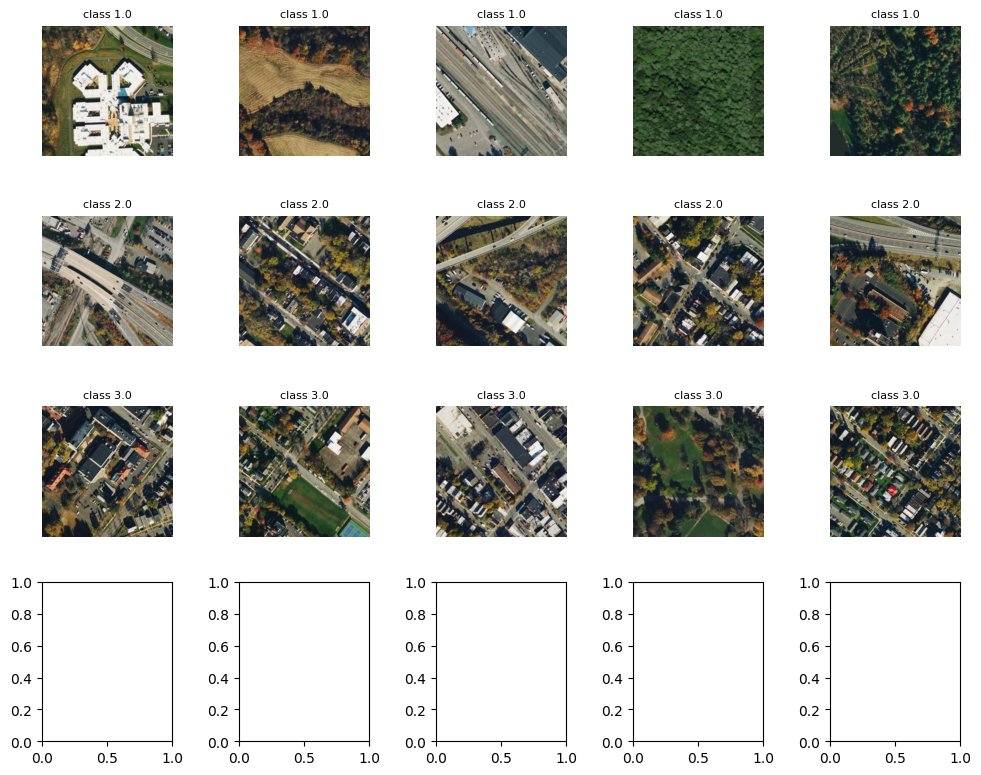

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# find the unique classes
classes = np.unique(labels)

# print 5 per class
n_per_class = 5

# set up a grid: rows = classes, cols = num per class
fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class * 2, len(classes) * 2))

for row, cls in enumerate(classes):
    # generate indices
    idxs = np.where(labels == cls)[0]
    # pick 5
    chosen = idxs[:n_per_class]

    for col, idx in enumerate(chosen):
        ax = axes[row, col] if len(classes) > 1 else axes[col]
        ax.imshow(imgs[idx])
        ax.set_title(f'class {cls}', fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.show()


# Use a pre-trained model

Prep for VGG-16 input.

In [28]:
# first, split off 10% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    imgs_small, labels_small,
    test_size    = 0.1,
    random_state = 100,
    shuffle      = True
)

# then split the remaining 90% into 80% train / 10% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size    = 0.1 / 0.9,
    random_state = 100,
    shuffle      = True
)

# 2) wrap them as tf.data.Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test,  y_test))

# 3) define your preprocess fn
def preprocess(image, label):
    # ensures image is float32 in [0,255], resizes, then applies VGG16 preprocessing
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image, label

# 4) map, batch, prefetch
batch_size = 32

train_dataset = (
    train_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1024)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [29]:
# Get the convolutional layers from the VGG16 model and configure to needs.
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
import numpy as np

# grab one batch
images_batch, labels_batch = next(iter(train_dataset))

# 1) input shape is the spatial+channel dims of the image
input_shape = images_batch.shape[1:]   # -> (224, 224, 3)

# 2) num_classes is the count of unique labels (as a Python int)
num_classes = int(np.unique(labels_small).size)
# or equivalently:
# num_classes = int(labels_batch.numpy().max() + 1)

print('input_shape:', input_shape, 'types:', [type(d) for d in input_shape])
print('num_classes:', num_classes, type(num_classes))


input_shape: (224, 224, 3) types: [<class 'int'>, <class 'int'>, <class 'int'>]
num_classes: 3 <class 'int'>


In [32]:
def get_features_and_labels(dataset, conv_base):
    conv_base.trainable = False
    processed_images = preprocess_input(dataset)
    return processed_images

def build_dense_model(input_shape, num_classes):
    # 1) Inputs
    inputs = keras.Input(shape=input_shape)

    # 2) Flatten → Dense → Dropout
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    # 3) Final classification layer
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    # 4) Build & compile
    model = keras.Model(inputs, outputs)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def build_finetune_model(
    conv_base,
    input_shape,
    num_classes,
    fine_tune=False,
    fine_tune_at=4,
    head_units=512,
    dropout=0.3,
    base_learning_rate=1e-5
):
    # 1) optionally unfreeze the top `fine_tune_at` layers of conv_base
    conv_base.trainable = fine_tune
    if fine_tune:
        # freeze all layers except the last `fine_tune_at`
        for layer in conv_base.layers[:-fine_tune_at]:
            layer.trainable = False

    # 2) build your model by chaining conv_base→head
    inputs = keras.Input(shape=input_shape)
    x = conv_base(inputs, training=not fine_tune)   # ensure correct BN behavior
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(head_units, activation='relu')(x)
    x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # 3) compile with a smaller LR if fine-tuning
    lr = base_learning_rate if fine_tune else 1e-3
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Pre-trained model from imagenet.

In [33]:
# clear any old models
backend.clear_session()

# load conv base, freeze weights
conv_base = applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
conv_base.trainable = False

# build a small head
model2 = models.Sequential([
    conv_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# create weights for the classes

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# y_train: your full 1D array of training labels (e.g. from labels_small or train_dataset)
y_train = np.concatenate([y.numpy() for labels_small, y in train_dataset], axis=0)

# compute weights: array of shape (num_classes,)
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# convert to dict {class_index: weight}
class_weights = {int(cls): float(w)
                 for cls, w in zip(np.unique(y_train), class_weights_arr)}

print('class_weights =', class_weights)


class_weights = {0: 1.6161616161616161, 1: 0.7820136852394917, 2: 0.9070294784580499}


In [35]:
import matplotlib.pyplot as plt
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]

history = model2.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 620s 25s/step - accuracy: 0.3646 - loss: 1.4524 - val_accuracy: 0.3300 - val_loss: 1.1693
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 594s 24s/step - accuracy: 0.3655 - loss: 1.2693 - val_accuracy: 0.3300 - val_loss: 1.1387
Epoch 3/10


KeyboardInterrupt: 

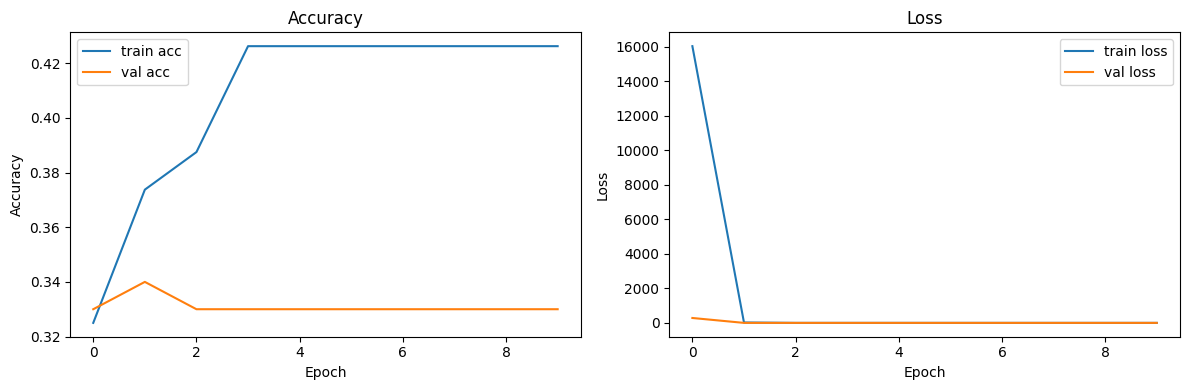

In [ ]:
# plot results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],    label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],        label='train loss')
plt.plot(history.history['val_loss'],    label='val loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


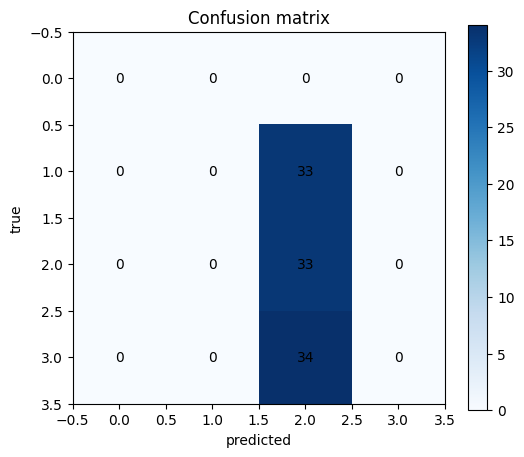

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# gather true & predicted on val set
y_true, y_pred = [], []
for x_batch, y_batch in val_dataset:
    preds = dense_model.predict(x_batch).argmax(axis=1)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('predicted'); plt.ylabel('true')
plt.title('Confusion matrix')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()


# Train CNN from scratch

## Building the model

Prep data for model.

In [28]:
# set batch size
batch_size = 32

# build a tf dataset from sample
ds = tf.data.Dataset.from_tensor_slices((imgs_small, labels_small))

# shuffle and split into train/val/test 80/10/10
ds = ds.shuffle(buffer_size=len(imgs_small), seed=100)

train_size = int(0.8 * len(imgs_small))
val_size   = int(0.1 * len(imgs_small))
test_size  = len(imgs_small) - train_size - val_size

# create datasets with new parameters
train_ds = ds.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = ds.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = ds.skip(train_size + val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Define model parameters.


*   3 convolutional blocks with pooling
*   Dense + dropout at .5



In [29]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # conv 1
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        # conv 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        # conv 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        # flatten and classify
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# set parameters
input_shape = imgs_small.shape[1:]
num_classes = len(set(labels_small))
cnn = build_cnn(input_shape, num_classes)

# print summary
cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Run the model.

In [30]:
callbacks = [
    ModelCheckpoint(
        'scratch_cnn_best.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.4993 - loss: 1.3397 - val_accuracy: 0.7500 - val_loss: 0.5692
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.7977 - loss: 0.5243 - val_accuracy: 0.8800 - val_loss: 0.3498
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8602 - loss: 0.4094 - val_accuracy: 0.8450 - val_loss: 0.3690
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8616 - loss: 0.3668 - val_accuracy: 0.8100 - val_loss: 0.4462
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.8595 - loss: 0.3843 - val_accuracy: 0.8700 - val_loss: 0.3232
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.8631 - loss: 0.3510 - val_accuracy: 0.9250 - val_loss: 0.2225
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.8926 - loss: 0.2734 - val_accuracy: 0.8650 - val_loss: 0.3182
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.8821 - loss: 0.3107 - val_accuracy: 0.9050 - v

## Model evaluation

Plotting train/val loss and accuracy.

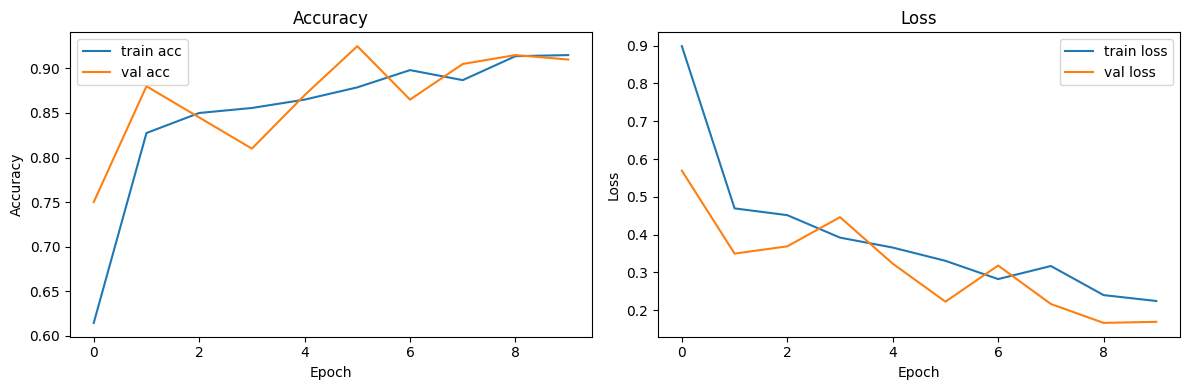

In [31]:
# plot results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],    label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],        label='train loss')
plt.plot(history.history['val_loss'],    label='val loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


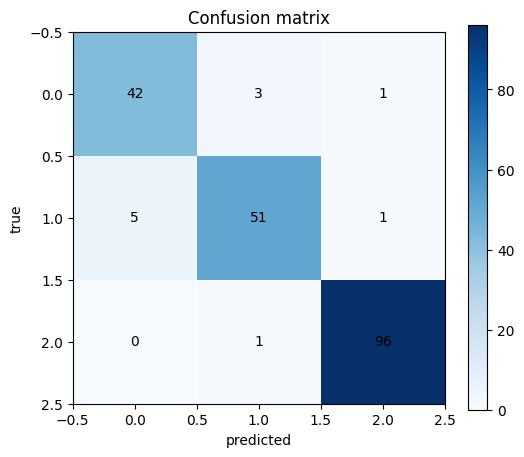

In [32]:
# values on val set
y_true, y_pred = [], []
for x_batch, y_batch in val_ds:
    preds = cnn.predict(x_batch).argmax(axis=1)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

# print matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('predicted'); plt.ylabel('true')
plt.title('Confusion matrix')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()


Save the model for future use.

In [37]:
print(os.getcwd())
cnn.save('documents/rural_suburban_urban_classifier.keras')